In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import re

from tqdm import tqdm

random_state = 12345

import json
import os

In [2]:
train_ds = pd.read_csv('data/train_dataset.csv')
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37224 entries, 0 to 37223
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          37224 non-null  object 
 1   time          37224 non-null  int64  
 2   target        37224 non-null  float64
 3   temp          37224 non-null  float64
 4   temp_pred     37136 non-null  float64
 5   weather_pred  37136 non-null  object 
 6   weather_fact  37223 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 2.0+ MB


In [3]:
train_ds['date'] = pd.to_datetime(train_ds['date'])
train_ds['year'] = train_ds['date'].dt.year
train_ds['month'] = train_ds['date'].dt.month
train_ds['day_of_week'] = train_ds['date'].dt.dayofweek
train_ds['day'] = train_ds['date'].dt.day
train_ds['day_of_year'] = train_ds['date'].dt.dayofyear

In [4]:
# функция формирует колонки 'cloudy', 'rainy', 'windy', 'clear', 'some_number'
# в колонках число, которое 0 при отсутсвии упоминания явления в weather_pred или степень упоминания
# функция дает в колонках номер первого списка, элемент которого есть в строке плюс 1
# списки cloudy_list, rainy_list, windy_list, clear_list можно модифицировать
# соответственно, можно экспериментировать с расположением значений в списках
# например, сейчас 'дождь', 'снег', 'д+сн' - первая степень  дождя, а 'гроз', 'ливень' - вторая
# а можно сделать снег второй, а грозу с ливнем убрать в третью
# также сделал отдельный список для "ясности", чтобы выделить 'ясно' и 'солнечно'

def in_what_list(weather, big_list):
    for list_number, small_list in enumerate(big_list):
        if any(word in weather for word in small_list):
            return list_number+1
    return 0

def weather_split2(row):
    weather = row['weather_pred']
    cloudy_list = [['проясн', 'пер.об.', 'п/об'], ['пасм', 'обл']]
    rainy_list = [['дождь', 'снег', 'д+сн'], ['гроз', 'ливень']]
    windy_list = [['вет'],['штор']]
    clear_list = [['проясн'], ['ясно'], ['солнеч']]
    numbers = re.findall(r'\d+', weather)
    cloudy = in_what_list(weather, cloudy_list)
    rainy = in_what_list(weather, rainy_list)
    windy = in_what_list(weather, windy_list)
    clear = in_what_list(weather, clear_list)
    rain_probability = 0 if len(numbers)==0 else int(numbers[0])
    has_rain_probability = int(len(numbers)==0)
    return cloudy, rainy, windy, clear, rain_probability, has_rain_probability

def fill_weather_columns(df):
    df['weather_pred'] = df['weather_pred'].fillna('')
    df['cloudy'], df['rainy'], df['windy'], df['clear'], df['rain_probability'], df['has_rain_probability'] = \
                zip(*df.apply(weather_split2, axis=1))
    return df

train_ds = fill_weather_columns(train_ds)



In [5]:
#tmpds[(tmpds['cloudy']==0) & (tmpds['clear']==0) & (tmpds['rainy']==0)]['weather_pred'].value_counts()

In [6]:
train_ds.columns

Index(['date', 'time', 'target', 'temp', 'temp_pred', 'weather_pred',
       'weather_fact', 'year', 'month', 'day_of_week', 'day', 'day_of_year',
       'cloudy', 'rainy', 'windy', 'clear', 'rain_probability',
       'has_rain_probability'],
      dtype='object')

In [7]:
train_ds.head()

,date,time,target,temp,temp_pred,weather_pred,weather_fact,year,month,day_of_week,day,day_of_year,cloudy,rainy,windy,clear,rain_probability,has_rain_probability
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер,2019,1,1,1,1,2,0,1,0,0,1
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер,2019,1,1,1,1,2,0,1,0,0,1
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер,2019,1,1,1,1,2,0,1,0,0,1
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,1,1,2,0,1,0,0,1
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,1,1,2,0,1,0,0,1


In [9]:
folder_path = 'data/celebrates'

# Получаем список всех файлов JSON в папке
json_files = [file for file in os.listdir(folder_path) if file.endswith('.json')]

# Создаем пустой датафрейм для хранения данных
df_holidays = pd.DataFrame()
print(json_files)
# Проходим по каждому файлу JSON
for json_file in json_files:
    # Открываем файл и загружаем данные
    print(json_file)
    with open(os.path.join(folder_path, json_file), 'r') as file:
        data = json.load(file)
    
    # Преобразуем списки в датафреймы
    df_holidays_json = pd.DataFrame(data['holidays'], columns=['date'])
    df_preholidays_json = pd.DataFrame(data['preholidays'], columns=['date'])
    print(df_holidays_json.head())
    # Добавляем столбцы для праздников и предпраздничных дней
    df_holidays_json['holidays'] = 1
    df_preholidays_json['preholidays'] = 1

    # Объединяем датафреймы
    temp_df = pd.concat([df_holidays_json, df_preholidays_json])

    # Заполняем пропущенные значения нулями
    temp_df.fillna(0, inplace=True)

    # Добавляем временный датафрейм в общий датафрейм
    df_holidays = pd.concat([df_holidays, temp_df])

# Преобразуем столбец 'date' в формат datetime
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

df_holidays.fillna(0, inplace=True)
df_holidays.to_csv('data/holidays.csv', index=False)
# Выводим первые строки датафрейма
print(df_holidays.sample(10))

['superjob2019.json', 'superjob2023.json', 'superjob2022.json', 'superjob2021.json', 'superjob2020.json']
superjob2019.json
         date
0  2019-01-01
1  2019-01-02
2  2019-01-03
3  2019-01-04
4  2019-01-05
superjob2023.json
         date
0  2023-01-01
1  2023-01-02
2  2023-01-03
3  2023-01-04
4  2023-01-05
superjob2022.json
         date
0  2022-01-01
1  2022-01-02
2  2022-01-03
3  2022-01-04
4  2022-01-05
superjob2021.json
         date
0  2021-01-01
1  2021-01-02
2  2021-01-03
3  2021-01-04
4  2021-01-05
superjob2020.json
         date
0  2020-01-01
1  2020-01-02
2  2020-01-03
3  2020-01-04
4  2020-01-05
          date  holidays  preholidays
90  2023-10-01       1.0          0.0
7   2020-01-08       1.0          0.0
42  2022-05-01       1.0          0.0
115 2020-12-19       1.0          0.0
30  2021-03-20       1.0          0.0
0   2022-01-01       1.0          0.0
98  2020-10-24       1.0          0.0
87  2021-09-25       1.0          0.0
103 2022-11-12       1.0          0.0
0   

In [15]:
print(df_holidays.info())
print(df_holidays.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 612 entries, 0 to 4
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         612 non-null    datetime64[ns]
 1   holidays     612 non-null    float64       
 2   preholidays  612 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 19.1 KB
None
0


In [9]:
# Assuming df_holidays and train_ds are your dataframes
train_ds = pd.merge(train_ds, df_holidays, on='date', how='left')

# Fill NaN values with 0
train_ds['holidays'].fillna(0, inplace=True)
train_ds['preholidays'].fillna(0, inplace=True)

# Convert to int
train_ds['holidays'] = train_ds['holidays'].astype(int)
train_ds['preholidays'] = train_ds['preholidays'].astype(int)

In [10]:
train_ds.head()

,date,time,target,temp,temp_pred,weather_pred,weather_fact,year,month,day_of_week,day,day_of_year,cloudy,rainy,windy,clear,rain_probability,has_rain_probability,holidays,preholidays
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер,2019,1,1,1,1,2,0,1,0,0,1,0,0
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер,2019,1,1,1,1,2,0,1,0,0,1,0,0
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер,2019,1,1,1,1,2,0,1,0,0,1,0,0
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,1,1,2,0,1,0,0,1,0,0
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",2019,1,1,1,1,2,0,1,0,0,1,0,0


In [11]:
# создаем столбец 'temp_last_day'
train_ds['temp_last_day'] = train_ds['temp'].shift(24) # погода сутки назад
# Среднюю температуру сутки назад
# Максимальную температуру сутки назад
# Минимальный  температуру сутки назад
# заполняем пропущенные значения в 'temp_last_day'
train_ds['temp_last_day'].fillna(method='bfill', inplace=True)

# создаем столбцы с временными лагами для 'target'
lags = [24, 48, 72, 7*24, 14*24]
for lag in lags:
    train_ds[f'target_lag_{lag}'] = train_ds['target'].shift(lag)

# заполняем пропущенные значения в столбцах с лагами
for lag in lags:
    train_ds[f'target_lag_{lag}'].fillna(0, inplace=True)

/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/ipykernel_8747/2611611343.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_ds['temp_last_day'].fillna(method='bfill', inplace=True)


In [12]:
train_ds = train_ds.drop('temp', axis=1)

In [13]:
train_ds.head()

,date,time,target,temp_pred,weather_pred,weather_fact,year,month,day_of_week,day,...,rain_probability,has_rain_probability,holidays,preholidays,temp_last_day,target_lag_24,target_lag_48,target_lag_72,target_lag_168,target_lag_336
0,2019-01-01,0,481.510,2.0,"пасм, ветер",ветер,2019,1,1,1,...,0,1,0,0,2.9,0.0,0.0,0.0,0.0,0.0
1,2019-01-01,1,462.872,2.0,"пасм, ветер",ветер,2019,1,1,1,...,0,1,0,0,2.9,0.0,0.0,0.0,0.0,0.0
2,2019-01-01,2,449.718,2.0,"пасм, ветер",ветер,2019,1,1,1,...,0,1,0,0,2.9,0.0,0.0,0.0,0.0,0.0
3,2019-01-01,3,430.908,2.0,"пасм, ветер","ветер, пасм",2019,1,1,1,...,0,1,0,0,2.9,0.0,0.0,0.0,0.0,0.0
4,2019-01-01,4,415.163,2.0,"пасм, ветер","ветер, пасм",2019,1,1,1,...,0,1,0,0,2.9,0.0,0.0,0.0,0.0,0.0


In [14]:
feature_cols = list(train_ds.columns)
drop_list = ['target', 'date', 'day_of_year', 'weather_pred', 'weather_fact']
for name in drop_list:
    feature_cols.remove(name)

feature_cols

['time',
 'temp_pred',
 'year',
 'month',
 'day_of_week',
 'day',
 'cloudy',
 'rainy',
 'windy',
 'clear',
 'rain_probability',
 'has_rain_probability',
 'holidays',
 'preholidays',
 'temp_last_day',
 'target_lag_24',
 'target_lag_48',
 'target_lag_72',
 'target_lag_168',
 'target_lag_336']

In [15]:
features = train_ds[feature_cols]
target = train_ds['target']

In [16]:
features.head()

,time,temp_pred,year,month,day_of_week,day,cloudy,rainy,windy,clear,rain_probability,has_rain_probability,holidays,preholidays,temp_last_day,target_lag_24,target_lag_48,target_lag_72,target_lag_168,target_lag_336
0,0,2.0,2019,1,1,1,2,0,1,0,0,1,0,0,2.9,0.0,0.0,0.0,0.0,0.0
1,1,2.0,2019,1,1,1,2,0,1,0,0,1,0,0,2.9,0.0,0.0,0.0,0.0,0.0
2,2,2.0,2019,1,1,1,2,0,1,0,0,1,0,0,2.9,0.0,0.0,0.0,0.0,0.0
3,3,2.0,2019,1,1,1,2,0,1,0,0,1,0,0,2.9,0.0,0.0,0.0,0.0,0.0
4,4,2.0,2019,1,1,1,2,0,1,0,0,1,0,0,2.9,0.0,0.0,0.0,0.0,0.0


In [58]:
features_train = features[features['year']<2023]
target_train = target[features_train.index]
features_valid = features[features['year']==2023]
target_valid = target[features_valid.index]

In [18]:
features_train = features[features['year']<2022]
target_train = target[features_train.index]
features_valid = features[features['year']==2022]
target_valid = target[features_valid.index]

In [59]:
def mae_day(y_true, y_pred):
    y_true_copy = pd.DataFrame(y_true).reset_index(drop=True)
    y_true_copy['day'] = y_true_copy.index // 24
    y_true_grouped = y_true_copy.groupby(by='day').sum()   
    y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
    y_pred_copy['day'] = y_pred_copy.index // 24
    y_pred_grouped = y_pred_copy.groupby(by='day').sum()
    
    return mean_absolute_error(y_true_grouped, y_pred_grouped)

In [20]:
# класс предлагается инициализировать, затем брать значения параметра из current_value 
# и регистрировать значения метрики методом add_metric_value, пока add_metric_value не вернет True

# параметры инициализации: 
# initial_values - начальный вектор значений параметра, может быть любой длины
# stop_relation - целевое отношение соседних значений параметра для остановки поиска
# step_method - способ формирования трех точек для первой параболы дугой вниз
# step_method = 'geometric' - делим или умножаем значение с минимальной метрикой на geometric_step
# step_method = 'dichotomy' - делим интервал с минимальной метрикой на границах пополам
# step_method = 'geometric_dichotomy' - делим интервал с минимальной метрикой на границах средним геометрическим

class one_parameter_parabolic_optimizer:
    def __init__(self, initial_values, stop_relation=1.1, step_method='nothing', geometric_step=2):      
        self.data = pd.DataFrame(columns=('parameter','metric','x2','x','1'), dtype='float')
        self.parabolic_mode = False
        self.parabolic_error = False
        self.stop_relation_log = np.log(stop_relation)
        self.initial_values = initial_values            
        self.step_method = step_method                              
        self.geometric_step = geometric_step
        self.initial_counter = 0
        self.current_value = self.initial_values[0]
        
    def best_value(self):
        return self.data.loc[self.data['metric'].idxmin(), 'parameter']
    
# строим параболу через точку с минимальной метрикой и две соседние и ищем ее минимум
    def next_parabolic(self):                      
        self.data['x2'] = self.data['parameter']**2
        self.data['x'] = self.data['parameter']
        self.data['1'] = 1
        self.data = self.data.astype(float).sort_values(by='parameter', ascending=True).reset_index(drop=True)
        index_min = self.data['metric'].idxmin()
        matrix = self.data[['x2','x','1']][index_min-1:index_min+2]
        y = self.data['metric'][index_min-1:index_min+2]
        vector_abc = np.linalg.inv(matrix) @ y
        return -vector_abc[1]/vector_abc[0]/2

    def next_geometric(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return self.data.loc[index_min, 'parameter']/self.geometric_step
        else:
            return self.data.loc[index_min, 'parameter']*self.geometric_step
        
    def next_dichotomy(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return (self.data.loc[index_min, 'parameter'] + self.data.loc[index_min+1, 'parameter'])/2
        else:
            return (self.data.loc[index_min, 'parameter'] + self.data.loc[index_min-1, 'parameter'])/2
        
    def next_geometric_dichotomy(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return (self.data.loc[index_min, 'parameter'] * self.data.loc[index_min+1, 'parameter'])**0.5
        else:
            return (self.data.loc[index_min, 'parameter'] * self.data.loc[index_min-1, 'parameter'])**0.5
    
    def add_metric_value(self, metric_value):
        if self.parabolic_error:           # записана ошибка, выход
                return True
        self.data.loc[self.data.shape[0]] = [self.current_value, metric_value, 0, 0, 0]   # новое значение в таблицу
        if self.initial_counter+1 < len(self.initial_values) :              # если начальные значения не закончились,
            self.initial_counter+=1                                         # то считаем метрику в них
            self.current_value = self.initial_values[self.initial_counter]
            return False
        self.data = self.data.astype(float).sort_values(by='parameter', ascending=True).reset_index(drop=True)
        index_min = self.data['metric'].idxmin()         # ищем минимальную метрику
        parabolic_ready = (index_min!=0) and (index_min!=self.data.shape[0]-1)      # и выясняем, на краю ли она таблицы
        if parabolic_ready:
            self.parabolic_mode = True                               # если не на краю, дальше считаем параболой                  
            self.current_value = self.next_parabolic()
            loglog = abs(np.array([np.log(self.data.loc[index_min-1,'parameter'])-np.log(self.data.loc[index_min,'parameter']),
                              np.log(self.data.loc[index_min+1,'parameter']) -np.log(self.data.loc[index_min,'parameter'])]))            
            return loglog.min() < self.stop_relation_log   # пока не выполним критерий
        elif self.parabolic_mode:    # если уже была парабола, а теперь не получается, то пишем ошибку: метод расходится
            return True
        elif self.step_method == 'geometric': # если еще нет точек для параболы и задана геометрическая прогрессия
            self.current_value = self.next_geometric()
            return False
        elif self.step_method == 'dichotomy': # если еще нет точек для параболы и задана дихотомия 
            self.current_value = self.next_dichotomy()
            return False
        elif self.step_method == 'geometric_dichotomy': # если еще нет точек для параболы и задана geometric_dichotomy 
            self.current_value = self.next_geometric_dichotomy()
            return False
        else: # если еще нет точек для параболы и метод поиска не задан, завершаем
            return True

In [21]:
%%time
optimizer = one_parameter_parabolic_optimizer([0.1], 1.03, step_method='geometric')
for i in range(10):
    learning_rate = optimizer.current_value
    lgbm_model = lgb.LGBMRegressor(num_leaves=15, learning_rate=learning_rate, num_iterations=5000, random_state=random_state, objective='regression_l1', n_jobs=-1)
    lgbm_model.fit(features_train, target_train)
    mae = mae_day(target_valid, lgbm_model.predict(features_valid))
    print(f'learning rate = {learning_rate:.5f} mae = {mae:.1f}')
    if optimizer.add_metric_value(mae):
        break
best_learning_rate_1000 = optimizer.best_value()

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 29160, number of used features: 20
[LightGBM] [Info] Start training from score 461.328003


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sp

learning rate = 0.10000 mae = 163.0
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 29160, number of used features: 20
[LightGBM] [Info] Start training from score 461.328003


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

learning rate = 0.05000 mae = 160.0
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 29160, number of used features: 20
[LightGBM] [Info] Start training from score 461.328003


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

learning rate = 0.02500 mae = 159.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 29160, number of used features: 20
[LightGBM] [Info] Start training from score 461.328003


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

learning rate = 0.01250 mae = 157.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 29160, number of used features: 20
[LightGBM] [Info] Start training from score 461.328003


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

learning rate = 0.00625 mae = 156.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 29160, number of used features: 20
[LightGBM] [Info] Start training from score 461.328003


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

learning rate = 0.00313 mae = 161.1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 29160, number of used features: 20
[LightGBM] [Info] Start training from score 461.328003


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

learning rate = 0.00871 mae = 157.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 29160, number of used features: 20
[LightGBM] [Info] Start training from score 461.328003


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

learning rate = 0.00659 mae = 158.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 29160, number of used features: 20
[LightGBM] [Info] Start training from score 461.328003


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

learning rate = 0.00501 mae = 159.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 29160, number of used features: 20
[LightGBM] [Info] Start training from score 461.328003
learning rate = 0.00585 mae = 158.2
CPU times: user 2min 43s, sys: 3min 12s, total: 5min 56s
Wall time: 3min 19s


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

In [22]:
%%time
optimizer = one_parameter_parabolic_optimizer([0.2, 1], 1.03, step_method='dichotomy')
for i in range(10):
    feature_fraction = optimizer.current_value
    lgbm_model = lgb.LGBMRegressor(num_leaves=15, learning_rate=best_learning_rate_1000,  
                               num_iterations=5000, 
                               feature_fraction=feature_fraction, random_state=random_state, 
                               objective='regression_l1', n_jobs=-1)
    lgbm_model.fit(features_train, target_train)
    rmse = mae_day(target_valid, lgbm_model.predict(features_valid))
    print(f'feature_fraction = {feature_fraction:.5f} rmse = {rmse:.1f}')
    if optimizer.add_metric_value(rmse):
        break
best_feature_fraction = optimizer.best_value()

/opt/anaconda3/envs/p311/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 29160, number of used features: 20
[LightGBM] [Info] Start training from score 461.328003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

feature_fraction = 0.20000 rmse = 182.8
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 29160, number of used features: 20
[LightGBM] [Info] Start training from score 461.328003
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

feature_fraction = 1.00000 rmse = 156.1
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 29160, number of used features: 20
[LightGBM] [Info] Start training from score 461.328003
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

feature_fraction = 0.60000 rmse = 158.3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 29160, number of used features: 20
[LightGBM] [Info] Start training from score 461.328003
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

feature_fraction = 0.80000 rmse = 159.0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 29160, number of used features: 20
[LightGBM] [Info] Start training from score 461.328003
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

feature_fraction = 0.90000 rmse = 157.8
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 29160, number of used features: 20
[LightGBM] [Info] Start training from score 461.328003
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

feature_fraction = 0.95000 rmse = 158.5
[LightGBM] [Warning] feature_fraction is set=0.975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.975
[LightGBM] [Warning] feature_fraction is set=0.975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.975
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 29160, number of used features: 20
[LightGBM] [Info] Start training from score 461.328003
[LightGBM] [Warning] feature_fraction is set=0.975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.975
feature_fraction = 0.97500 rmse = 156.1
CPU times: user 2min 11s, sys: 3min 10s, total: 5min 21s
Wall time: 3min 36s


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

In [23]:
lgbm_model = lgb.LGBMRegressor(num_leaves=15, learning_rate=best_learning_rate_1000, num_iterations=10000, 
                               feature_fraction=best_feature_fraction, random_state=random_state, objective='regression_l1', n_jobs=-1)
lgbm_model.fit(features_train, target_train)

/opt/anaconda3/envs/p311/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.975
[LightGBM] [Warning] feature_fraction is set=0.975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.975
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 29160, number of used features: 20
[LightGBM] [Info] Start training from score 461.328003


LGBMRegressor(feature_fraction=0.975, learning_rate=0.00625, n_jobs=-1,
              num_iterations=10000, num_leaves=15, objective='regression_l1',
              random_state=12345)

In [24]:
y_pred = lgbm_model.predict(features_valid)
mae = mae_day(target_valid, y_pred)
print(f'mae_of_the_day - {mae}')
print(f'mae of the hour - {mean_absolute_error(target_valid, y_pred)}')

[LightGBM] [Warning] feature_fraction is set=0.975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.975
mae_of_the_day - 156.0416153830467
mae of the hour - 8.980687551461953


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

In [25]:
y_true_copy = pd.DataFrame(target_valid).reset_index(drop=True)
y_true_copy['day'] = y_true_copy.index // 24
y_true_grouped = y_true_copy.groupby(by='day').sum()   
y_true_grouped
y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
y_pred_copy['day'] = y_pred_copy.index // 24
y_pred_grouped = y_pred_copy.groupby(by='day').sum()

<Axes: xlabel='day'>

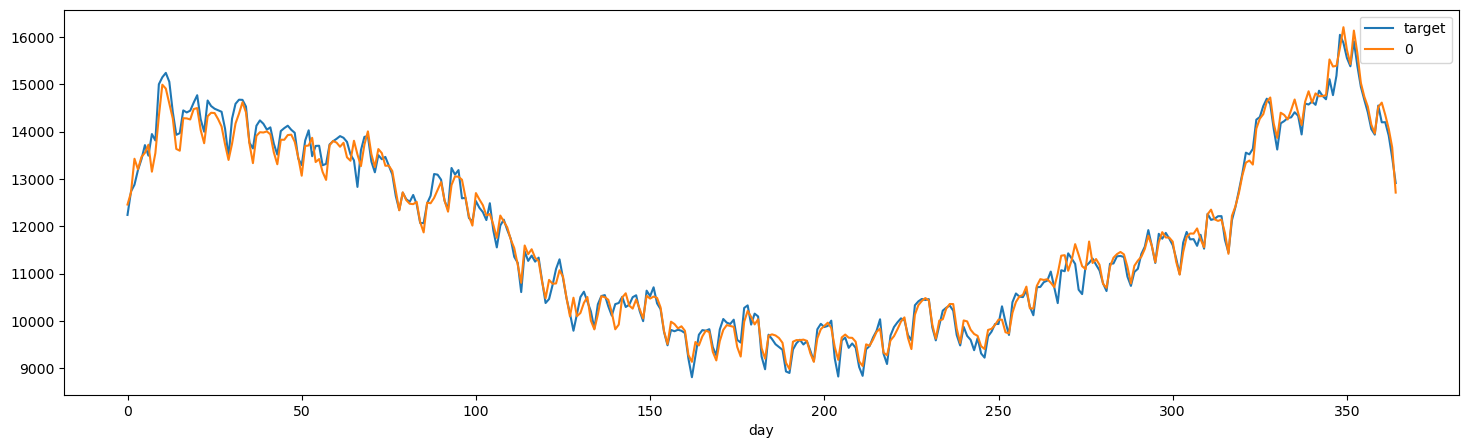

In [26]:
y_true_grouped.plot(figsize=(18,5))
ax=plt.gca()
y_pred_grouped.plot(ax=ax)

In [27]:
y_true_grouped['target'][1]

12734.276

<Axes: ylabel='0'>

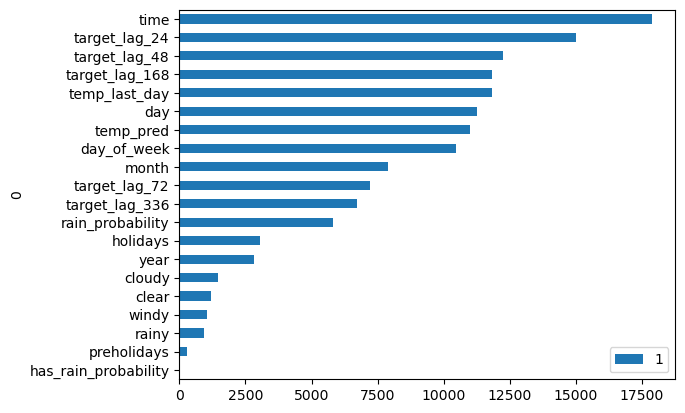

In [28]:
feature_importances = pd.DataFrame([feature_cols, lgbm_model.feature_importances_]).T.sort_values(by = 1)
#feature_importances.plot(kind='bar')
feature_importances.plot(kind='barh', x=0, y=1)

In [33]:
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 9.6 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 15.2 MB/s eta 0:00:00


In [34]:
# импортируем SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [37]:
display(features_train.tail())
display(target_train.head())
features_train.columns

,time,temp_pred,year,month,day_of_week,day,cloudy,rainy,windy,clear,rain_probability,has_rain_probability,holidays,preholidays,temp_last_day,target_lag_24,target_lag_48,target_lag_72,target_lag_168,target_lag_336
29155,19,7.0,2021,12,4,31,0,1,1,0,94,0,0,0,2.5,695.498,729.589,752.882,716.590,680.920
29156,20,7.0,2021,12,4,31,0,1,1,0,94,0,0,0,2.5,681.810,713.865,733.062,700.407,665.334
29157,21,7.0,2021,12,4,31,0,1,1,0,88,0,0,0,3.0,666.767,697.692,712.833,685.313,645.792
29158,22,7.0,2021,12,4,31,0,1,1,0,88,0,0,0,3.0,652.563,679.494,693.543,668.866,630.869
29159,23,7.0,2021,12,4,31,0,1,1,0,88,0,0,0,3.0,625.893,650.163,660.228,641.806,596.510


0    481.510
1    462.872
2    449.718
3    430.908
4    415.163
Name: target, dtype: float64

Index(['time', 'temp_pred', 'year', 'month', 'day_of_week', 'day', 'cloudy',
       'rainy', 'windy', 'clear', 'rain_probability', 'has_rain_probability',
       'holidays', 'preholidays', 'temp_last_day', 'target_lag_24',
       'target_lag_48', 'target_lag_72', 'target_lag_168', 'target_lag_336'],
      dtype='object')

### Дифферинцирование
Да, дифференцирование обычно применяется до разбиения данных на обучающую и тестовую выборки. Это связано с тем, что дифференцирование - это операция, которая использует информацию из предыдущих наблюдений временного ряда1. Если вы разделите данные на обучающую и тестовую выборки до дифференцирования, то у вас не будет доступа к всей необходимой информации при выполнении этой операции.

In [60]:
# Список признаков для дифференцирования
dif_cols = [ # 'temp_pred', 'temp_last_day', 
            'target_lag_24',
       'target_lag_48', 'target_lag_72', 'target_lag_168', 'target_lag_336']

def differentiate_features(features, target, cols):
    # Копирование DataFrame
    dif_features = features.copy()

    # Применение дифференцирования к каждому признаку
    for col in cols:
        dif_features[col] = dif_features[col].diff()

    # Дифференцирование целевой переменной
    diff_target = target.diff()

    # Удаление первой строки из обеих выборок
    dif_features = dif_features.iloc[1:]
    diff_target = diff_target.iloc[1:]

    return dif_features, diff_target

In [61]:

dif_features_train, diff_target_train = differentiate_features(features_train, target_train, dif_cols)
dif_features_val, diff_target_val = differentiate_features(features_valid, target_valid, dif_cols)

print(features_train.shape,target_train.shape )
dif_features_train.shape, diff_target.shape

(37920, 20) (37920,)


((37919, 20), (29159,))

In [62]:
lgbm_model_diff = lgb.LGBMRegressor(num_leaves=15, learning_rate=best_learning_rate_1000, num_iterations=10000, 
                               feature_fraction=best_feature_fraction, random_state=random_state, objective='regression_l1', n_jobs=-1)
lgbm_model_diff.fit(dif_features_train, diff_target_train)

/opt/anaconda3/envs/p311/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.975
[LightGBM] [Warning] feature_fraction is set=0.975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.975
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1784
[LightGBM] [Info] Number of data points in the train set: 37919, number of used features: 20
[LightGBM] [Info] Start training from score -1.129000


LGBMRegressor(feature_fraction=0.975, learning_rate=0.00625, n_jobs=-1,
              num_iterations=10000, num_leaves=15, objective='regression_l1',
              random_state=12345)

In [78]:
y_pred = lgbm_model_diff.predict(dif_features_val)

# Обратное преобразование прогноза
undiff_y_pred = y_pred.cumsum()  - diff_target_val.iloc[-1]

# Удаление первой строки из target_valid
target_valid_un = target_valid.iloc[1:]

mae = mae_day(target_valid_un, undiff_y_pred)
print(f'mae_of_the_day - {mae}')
print(f'mae of the hour - {mean_absolute_error(target_valid_un, undiff_y_pred)}')

[LightGBM] [Warning] feature_fraction is set=0.975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.975
mae_of_the_day - 27435.67974120387
mae of the hour - 1143.6828053304066


/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

In [76]:
y_true_copy = pd.DataFrame(target_valid_un).reset_index(drop=True)
y_true_copy['day'] = y_true_copy.index // 24
y_true_grouped = y_true_copy.groupby(by='day').sum()   
y_true_grouped
y_pred_copy = pd.DataFrame(undiff_y_pred).reset_index(drop=True)
y_pred_copy['day'] = y_pred_copy.index // 24
y_pred_grouped = y_pred_copy.groupby(by='day').sum()

<Axes: xlabel='day'>

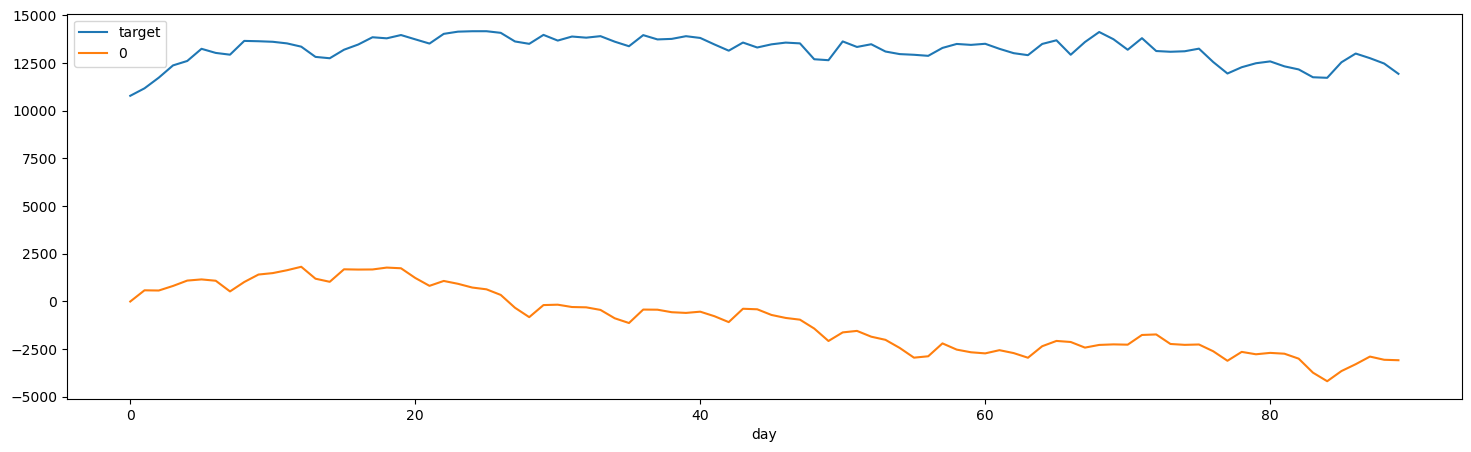

In [71]:
y_true_grouped.plot(figsize=(18,5))
ax=plt.gca()
y_pred_grouped.plot(ax=ax)